### Main Code Version for Sneaker Identifier Notebook

Lucas Ying
5/8/24


This was the main version for my Sneaker Identifier project which I coded in Python 3.10.6.

In [97]:
from PIL import Image
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow

# Assuming 'data' directory is at the same level as the script
TEST_DIR = './data/TestingData'
TRAIN_DIR = './data/TrainingData'

# Constants for image size and learning rate
IMG_SIZE = 120
LR = 1e-3

# Model naming convention using formatted strings
MODEL_NAME = f'OFFWHITEvsYEEZY-{LR}-2conv-basic.model'

# Display the revised constants and paths
TEST_DIR, TRAIN_DIR, IMG_SIZE, LR, MODEL_NAME


('./data/TestingData',
 './data/TrainingData',
 120,
 0.001,
 'OFFWHITEvsYEEZY-0.001-2conv-basic.model')

In [98]:
# Revised functions for labeling images and creating training and testing data

def label_img(img):
    """Extract label from image file name using one-hot encoding for two categories."""
    word_label = img.split('_')[0]
    if word_label == 'OFFWHITE':
        return [1, 0]
    elif word_label == 'YEEZY':
        return [0, 1]

# Enhanced error handling for image loading in training and testing data processing functions

def create_train_data_with_checks():
    """Generate training data from images, with checks to ensure images are loaded."""
    train_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        if path.endswith(".DS_Store"):
            break
        loaded_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if loaded_img is None:  # Check if the image was properly loaded
            if not path.endswith(".DS_Store"):  # Avoid printing warnings for .DS_Store
                print(f"Warning: Could not load image {path}")
            continue
        img = cv2.resize(loaded_img, (IMG_SIZE, IMG_SIZE))
        train_data.append([np.array(img), np.array(label)])
    shuffle(train_data)
    np.save('train_data.npy', train_data)
    return train_data

def process_test_data_with_checks():
    test_data = []
    for img_file in tqdm(os.listdir(TEST_DIR)):
        if img_file.endswith('.DS_Store') or not img_file.endswith('.jpg'):
            continue
        path = os.path.join(TEST_DIR, img_file)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img_num = img_file.split('_')[1].split('.')[0]  # Assume format like 'OFFWHITE_1.jpg'
        test_data.append([np.array(img, dtype=np.uint8), img_num])  # Ensure consistent data type
    np.save('test_data.npy', np.array(test_data, dtype=object))  # Using dtype=object for mixed types
    return test_data


# Output to verify new function definitions
create_train_data_with_checks, process_test_data_with_checks

(<function __main__.create_train_data_with_checks()>,
 <function __main__.process_test_data_with_checks()>)

In [99]:
# ChatGPT helped code this part
# Assuming the use of TensorFlow and Keras for neural network model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_model():
    model = Sequential([
        Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, (5, 5), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (5, 5), padding='same', activation='relu'),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Generating the model and printing the model summary to verify structure
cnn_model = create_model()
model_summary = cnn_model.summary()

# Output the model summary which provides insights into the total number of parameters
model_summary


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_111 (Conv2D)             │ (None, 120, 120, 64)   │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 60, 60, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 30, 30, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_37 (Flatten)            │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 1024)           │    58,983,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,089,634 (225.41 MB)

 Trainable params: 59,089,634 (225.41 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
# ChatGPT helped code this part
# Training and evaluation setup for the CNN model

def train_and_evaluate_model(model, train, test):
    X_train = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    Y_train = np.array([i[1] for i in train])
    X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    Y_test = np.array([i[1] for i in test])

    # Train the model
    model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, Y_test)
    return loss, accuracy


100%|██████████| 31/31 [00:00<00:00, 196.70it/s]


[array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), '5']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
[array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), '9']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), '7']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/

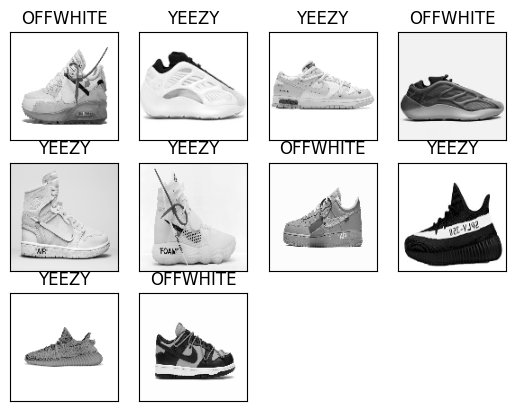

In [101]:
def plot_test_predictions(model, test_data):
    fig = plt.figure()
    for num, data in enumerate(test_data[:10]):
        print(data)
        img_data = data[0].reshape(IMG_SIZE, IMG_SIZE, 1)  # Correct reshaping
        model_out = model.predict(np.expand_dims(img_data, axis=0))[0]  # Correct input format for prediction
        str_label = 'YEEZY' if np.argmax(model_out) == 1 else 'OFFWHITE'
        y = fig.add_subplot(3, 4, num+1)
        y.imshow(img_data.squeeze(), cmap='gray')  # Use squeeze to remove singleton dimensions
        plt.title(str_label)
        y.axes.get_xaxis().set_visible(False)
        y.axes.get_yaxis().set_visible(False)
    plt.show()

model = create_model()  # Create your model
test_data = process_test_data_with_checks()  # Load your test data correctly
plot_test_predictions(model, test_data)  # Plot the predictions